# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [1]:
import matplotlib.pyplot as plt
import xarray as xr

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [3]:
# TODO: load the air temperature and precipitation datasets.

TIME_CHUNK = 30 

air = xr.open_dataset(TEMP_URL, chunks={"time": TIME_CHUNK})
precip = xr.open_dataset(PRECIP_URL, chunks={"time": TIME_CHUNK})


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [5]:
# TODO: subset both datasets using `sel`, handling coordinate ordering as needed.

lon_slice = slice(LON_RANGE_360[0], LON_RANGE_360[1]) 
lat_slice = slice(LAT_RANGE[1], LAT_RANGE[0])

air_us = air.sel(lat=lat_slice, lon=lon_slice, time=TIME_RANGE)
precip_us = precip.sel(lat=lat_slice, lon=lon_slice, time=TIME_RANGE)

print(air_us)
print(precip_us)


<xarray.Dataset> Size: 182kB
Dimensions:  (lat: 13, lon: 29, time: 120)
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Data variables:
    air      (time, lat, lon) float32 181kB dask.array<chunksize=(22, 13, 29), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension: 

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [6]:
# TODO: use xr.resample to create daily means.

air_daily = air_us["air"].resample(time="1D").mean()


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [7]:
# TODO: interpolate the resampled temperature field onto the precipitation grid.

air_interp = air_daily.interp(lat=precip_us["lat"],lon=precip_us["lon"])


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [18]:
# TODO: build datasets and merge them into one object named `merged`.

air_ds = air_interp.to_dataset(name="air_temperature")
precip_ds = precip_us["precip"].to_dataset(name="daily_precip")

merged = xr.merge([air_ds, precip_ds])


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [19]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(28, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


In [23]:
import os, certifi
os.environ["SSL_CERT_FILE"] = certifi.where()

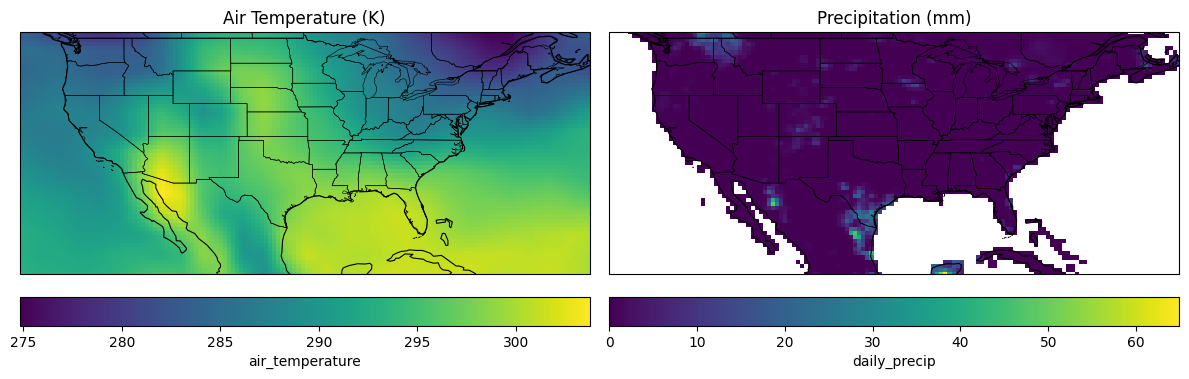

In [32]:
# Map plots at first timestep
t0 = merged.isel(time=0) # first timestep

lats = t0["lat"].values
lons = t0["lon"].values
lon_min, lon_max = float(lons.min()), float(lons.max())
lat_min, lat_max = float(lats.min()), float(lats.max())

proj = ccrs.PlateCarree()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": proj})

# air temp
pcm1 = ax1.pcolormesh(lons, lats, t0["air_temperature"], transform=proj, shading="auto")
ax1.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)
ax1.coastlines(resolution="110m", linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
ax1.set_title("Air Temperature (K)")
cb1 = plt.colorbar(pcm1, ax=ax1, orientation="horizontal", pad=0.05)
cb1.set_label("air_temperature")

# precip
pcm2 = ax2.pcolormesh(lons, lats, t0["daily_precip"], transform=proj, shading="auto")
ax2.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)
ax2.coastlines(resolution="110m", linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.4, edgecolor="black")
ax2.set_title("Precipitation (mm)")
cb2 = plt.colorbar(pcm2, ax=ax2, orientation="horizontal", pad=0.05)
cb2.set_label("daily_precip")

plt.tight_layout()
plt.show()

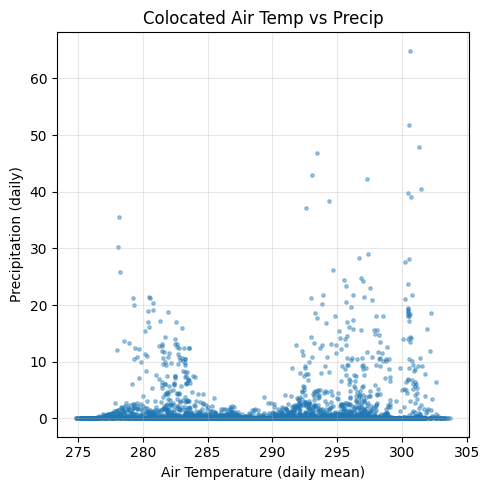

In [29]:
# Scatter of colocated values
import numpy as np

x = t0["air_temperature"].values.ravel()
y = t0["daily_precip"].values.ravel()
mask = (~np.isnan(x)) & (~np.isnan(y))

plt.figure(figsize=(5, 5))
plt.scatter(x[mask], y[mask], s=6, alpha=0.4)
plt.xlabel("Air Temperature (daily mean)")
plt.ylabel("Precipitation (daily)")
plt.title("Colocated Air Temp vs Precip")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Save merged dataset 

encoding = {
    "air_temperature": {"zlib": True, "complevel": 4},
    "daily_precip":   {"zlib": True, "complevel": 4},
}
out_path = "air_precip_merged_2020-06.nc"
merged.to_netcdf(out_path, encoding=encoding)
print(f"Saved: {out_path}")

Saved: air_precip_merged_2020-06.nc
